In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Thu Nov  7 16:09:12 2024


In [2]:
data = df_collector.cboe_spx_barriers().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
filetag = f'cboe spx {pricename[:pricename.find('_',0)]}'
data = data[data[pricename]<data['spot_price']]
data = data[data[pricename]>data['spot_price']*0.01].reset_index(drop=True)
og_count = data.shape[0]
print(f'collected {pricename[:pricename.find('_',0)]} options')
data

collected barrier options


,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price
0,4321.50000,3889.35000,2160.75000,60,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.03513,17.74179,-0.54338,3.56343,0.03250,2021-10-01 11:34:32.952,2021-10-01,480.94738
1,4321.50000,3889.35000,2160.75000,90,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.03513,17.74179,-0.54338,3.56343,0.03250,2021-10-01 11:34:32.952,2021-10-01,504.34686
2,4321.50000,3889.35000,2160.75000,180,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.03513,17.74179,-0.54338,3.56343,0.03250,2021-10-01 11:34:32.952,2021-10-01,570.23396
3,4321.50000,3889.35000,2160.75000,180,Down,Out,put,DownOut,0.00000,0.00000,0.04000,0.03513,17.74179,-0.54338,3.56343,0.03250,2021-10-01 11:34:32.952,2021-10-01,48.17035
4,4321.50000,3889.35000,2160.75000,360,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.03513,17.74179,-0.54338,3.56343,0.03250,2021-10-01 11:34:32.952,2021-10-01,687.50403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18005217,5813.50000,6394.85000,8720.25000,540,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,598.88951
18005218,5813.50000,6394.85000,8720.25000,540,Up,In,call,UpIn,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,87.93904
18005219,5813.50000,6394.85000,8720.25000,720,Up,Out,call,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,377.39147
18005220,5813.50000,6394.85000,8720.25000,720,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,650.45980


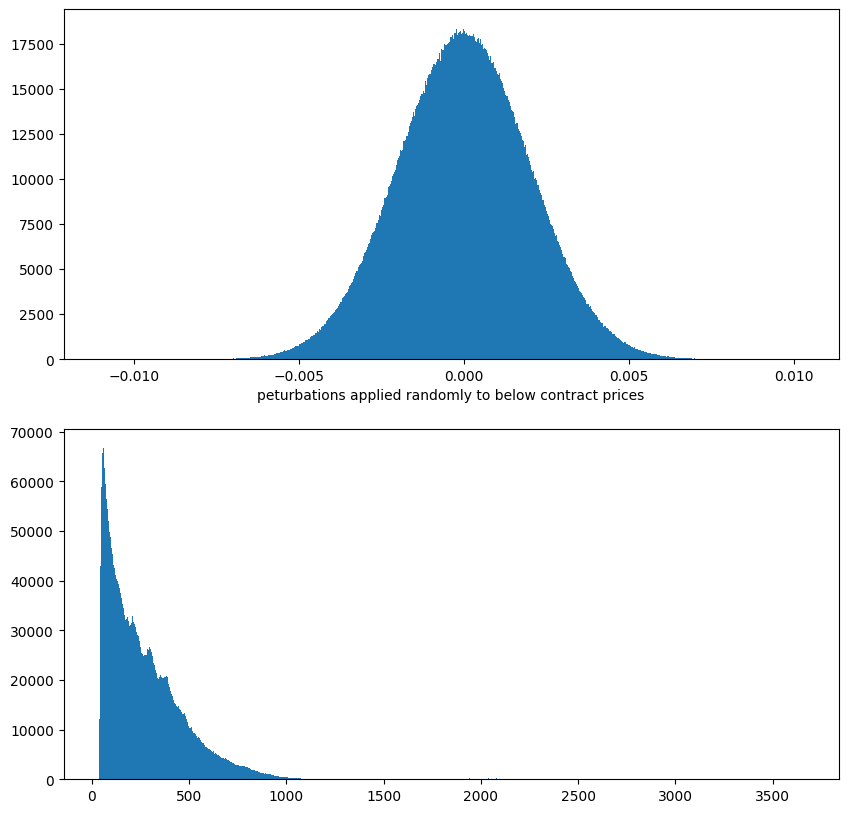

In [3]:
data = data[data[pricename]<data['spot_price']]
data = data[data[pricename]>data['spot_price']*0.01].reset_index(drop=True)

data['observed_price'] = data[pricename].apply(lambda x: max(x + np.random.normal(scale=0.002),0) if x > 0 else 0)
data = data[data['observed_price']>0]

p = data[pricename]-data['observed_price']
plotprices = data['observed_price']

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(p,bins=int(len(p)**0.5))
axs[0].set_xlabel('peturbations applied randomly to below contract prices')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5))
plt.show()

# training procedure

In [4]:
from convsklearn import convsklearn
trainer = convsklearn()
help(trainer)
print('instance variables:')
trainer.__dict__

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object

instance variables:


{'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'observed_price',
 'excluded_features': ['barrier_price',
  'asian',
  'observed_price',
  'outin',
  'updown',
  'n_fixings'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [5]:
trainer.load_data(data)
trainer.__dict__
trainer.dataset

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price,observed_price
0,4321.50000,3889.35000,2160.75000,60,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.03513,17.74179,-0.54338,3.56343,0.03250,2021-10-01 11:34:32.952,2021-10-01,480.94738,480.94794
1,4321.50000,3889.35000,2160.75000,90,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.03513,17.74179,-0.54338,3.56343,0.03250,2021-10-01 11:34:32.952,2021-10-01,504.34686,504.34747
2,4321.50000,3889.35000,2160.75000,180,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.03513,17.74179,-0.54338,3.56343,0.03250,2021-10-01 11:34:32.952,2021-10-01,570.23396,570.23396
3,4321.50000,3889.35000,2160.75000,180,Down,Out,put,DownOut,0.00000,0.00000,0.04000,0.03513,17.74179,-0.54338,3.56343,0.03250,2021-10-01 11:34:32.952,2021-10-01,48.17035,48.17289
4,4321.50000,3889.35000,2160.75000,360,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.03513,17.74179,-0.54338,3.56343,0.03250,2021-10-01 11:34:32.952,2021-10-01,687.50403,687.50375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18005217,5813.50000,6394.85000,8720.25000,540,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,598.88951,598.89131
18005218,5813.50000,6394.85000,8720.25000,540,Up,In,call,UpIn,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,87.93904,87.93701
18005219,5813.50000,6394.85000,8720.25000,720,Up,Out,call,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,377.39147,377.39002
18005220,5813.50000,6394.85000,8720.25000,720,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,650.45980,650.46159


## preprocessing

In [6]:
dates = pd.Series(np.sort(data['date'].unique()))
dates

0      2021-10-01
1      2021-10-04
2      2021-10-05
3      2021-10-06
4      2021-10-07
          ...    
757    2024-10-09
758    2024-10-10
759    2024-10-11
760    2024-10-14
761    2024-10-15
Length: 762, dtype: object

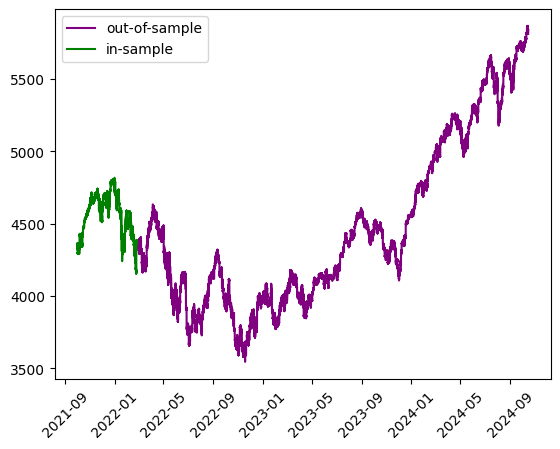

In [7]:
development_dates = dates[:100]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [8]:
trainer.run_dnn()


training on 2527776 samples...

alpha: 0.01
hidden_layer_sizes: (14, 14)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 3196.0012900829315


In [9]:
print('instance varianbles:')
trainer.__dict__

instance varianbles:


{'raw_data':           spot_price  strike_price    barrier  days_to_maturity updown outin  \
 0         4321.50000    3889.35000 2160.75000                60   Down   Out   
 1         4321.50000    3889.35000 2160.75000                90   Down   Out   
 2         4321.50000    3889.35000 2160.75000               180   Down   Out   
 3         4321.50000    3889.35000 2160.75000               180   Down   Out   
 4         4321.50000    3889.35000 2160.75000               360   Down   Out   
 ...              ...           ...        ...               ...    ...   ...   
 18005217  5813.50000    6394.85000 8720.25000               540     Up   Out   
 18005218  5813.50000    6394.85000 8720.25000               540     Up    In   
 18005219  5813.50000    6394.85000 8720.25000               720     Up   Out   
 18005220  5813.50000    6394.85000 8720.25000               720     Up   Out   
 18005221  5813.50000    6394.85000 8720.25000               720     Up    In   
 
              

In [10]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'barrier',
                                                                                        'days_to_maturity',
                                                                                        'rebate',
                                                                                        'dividend_rate',
                                                                                        'risk_free_rate',
                                                                                        'theta',
                                                                                        'kappa',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['w',
                                                                                        'barrier_type_name'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(14,
                                                                                       14),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())

### initial test

In [11]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 60.77392323923502
     MAE: 30.69657146959189

out of sample:
     RMSE: 227.97702553104867
     MAE: 106.02685780335693


## saving

In [12]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_07 170416543309 cboe spx barrier

cpu: 3304.131736278534
